In [1]:
import re
import os
import numpy as np
import pandas as pd
import nltk 
from nltk.corpus import stopwords
from numpy import dot
from numpy.linalg import norm

In [2]:
keywords = ["personal","projects","experience","skills","education"]


stop_words = stopwords.words('english')

In [3]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    # resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = [x for x in resumeText.split() if x not in stop_words]     #Removing stopwords
    return resumeText

In [4]:

MAX_SEQUENCE_LENGTH = 100
MAX_WORDS = None



In [5]:
def read_txt (path_to_folder, dir):
    indexes = []
    categories = {}
    for w in keywords:
        categories[w] = []
    for filename in dir:
        file = open(path_to_folder + filename,'r')
        read = file.read()
        read = read.lower()
        file.close()

        read = cleanResume(read)

        hash = {}
        hash["personal"] =0
        for word in keywords:
            if word in read:
                hash[word] = read.index(word)


        items = sorted(hash.items(), key = lambda x: x[1])
        for i in range(len(items)):
            start = items[i][1]
            end = None
            if (i+1)==len(items):
                end = len(read)
            else:
                end = items[i+1][1]

            categories[items[i][0]].append(read[start:end])

        for w in keywords:
            if w not in hash.keys():
                categories[w].append('None') 

        indexes.append(filename)
    return  categories, indexes

In [6]:
dir = os.listdir('./train_txt/')
categories, indexes = read_txt('./train_txt/',dir)

In [7]:
data = []
words_dict = ['None']
for i in range(len(indexes)):
    row = []
    for w in keywords:
        row.append(categories[w][i])
        if categories[w][i] is not  None:
            words_dict+=categories[w][i]

    data.append(row)

In [17]:
df = pd.DataFrame(data, index=indexes, columns=keywords)
df

,personal,projects,experience,skills,education
candidate_000.txt,"[personal, profile, actively, seeking, opportu...","[projects, music, genre, classification, face,...",None,"[skills, python, sql, mysql, tableau, power, b...","[education, b, tech, ece, vit, ap, university,..."
candidate_001.txt,"[brianna, williams, junior, developer, executi...","[projects, also, contribute, knowledge, logica...","[experience, curiosity, driven, data, scientis...","[skills, towards, consistent, growth, developm...","[education, teamwork, bsc, ca, mamco, universi..."
candidate_002.txt,"[mason, quadrado, associate, analyst, certifie...",None,"[experience, analyzing, interpreting, data, go...","[skills, python, machine, learning, mysql, dat...","[education, b, tech, b, e, electronics, teleco..."
candidate_003.txt,"[associate, software, engineer]","[projects, koy, ok, 1e, im, ge, tena, wal, tur...","[experience, software, engineer, machine, lear...","[skills, ava, alo, avin, zt, od, al, ms, 1, da...","[education, b, tech, v, v, 2018, activities, a..."
candidate_006.txt,"[jennifer, armstrong, computer, vision, enthus...","[projects, understanding, images, gan, based, ...","[experience, currently, professional, experience]","[skills, machine, learning, deep, learning, co...","[education, b, tech, computer, science, iit, g..."
...,...,...,...,...,...
candidate_144.txt,"[benjamin, osta, fresher, developer, professio...","[projects, proficient]",None,"[skills, software, engineer, software, develop...",None
candidate_145.txt,"[jerome, pelinsky, big, data, analyst, big, da...",None,"[experience, handling, kinds, data, also, used...","[skills, big, data, hadoop, hive, python, mapr...","[education, b, tech, electronics, amity, schoo..."
candidate_147.txt,"[jaroslav, chechnik, executive, profile, work]","[projects, music, genre, classification, face,...","[experience, looking, job, opportunity, expert...","[skills, b, tech, ece, vit, ap, university, 20...",[education]
candidate_148.txt,"[data, scientist]","[projects, acvaline, daal, lan, el, kx, 1e, mm...","[experience, building, deploying, end, end, an...","[skills, dy, esxoll, alot, dy, ha, wy, val, hv...","[education, b, tech, b, e, computers, rajiv, g..."


In [18]:
dir = ['Job description.txt']
cat, _ = read_txt('./', dir)

In [19]:
embeddings_dict = {}
embed_keys = []
with open("glove.6B.100d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        embed_keys.append(word)
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [20]:
jd_vec = {}
unks = 0
for w in keywords:
    vecs = []
    for word in cat[w][0]:
        if word in embed_keys:
            vecs.append(embeddings_dict[word])
        else:
            unks+=1
            vecs.append(embeddings_dict['<unk>'])
    vecs = np.array(vecs)
    avg = np.average(vecs, axis = 0)
    jd_vec[w] = avg

print("Total unk tokens" , unks)

Total unk tokens 10


In [21]:
sim_df = []
unks=0
all_words = []
for i in range(len(indexes)):
    row = []
    for w in keywords:
        vecs = []
        for word in categories[w][i]:
            all_words.append(word)
            if word in embed_keys:
                vecs.append(embeddings_dict[word])
            else:
                unks+=1
                vecs.append(embeddings_dict['<unk>'])
        vecs = np.array(vecs)
        va = np.average(vecs, axis = 0)
        cosine = None
        if np.isnan(va).any():
            cosine = 0
        else:
            vb = jd_vec[w]
            cosine = dot(va,vb)/(norm(va)*norm(vb))
        
        row.append(cosine)
    
    sim_df.append(row)

all_words = set(all_words)
print("Total words extracted are ", len(all_words))
print("Total unk tokens" , unks)

C:\Users\sriva\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\sriva\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Total words extracted are  2319
Total unk tokens 450


In [22]:
# Similartiy Table
similariy = pd.DataFrame(sim_df, index=indexes, columns=keywords)
similariy

,personal,projects,experience,skills,education
candidate_000.txt,0.888378,0.295928,0.415252,0.636419,0.856955
candidate_001.txt,0.610979,0.234160,0.776972,0.762761,0.882273
candidate_002.txt,0.668103,1.000000,0.620666,0.924627,0.754305
candidate_003.txt,0.694706,0.378404,0.694232,0.825477,0.770898
candidate_006.txt,0.906714,0.300554,0.769333,0.881404,0.773082
...,...,...,...,...,...
candidate_144.txt,0.900714,0.164987,0.415252,0.853482,0.393262
candidate_145.txt,0.738020,1.000000,0.758193,0.920389,0.725882
candidate_147.txt,0.576090,0.273347,0.758924,0.730275,0.708900
candidate_148.txt,0.698836,0.395247,0.733054,0.694591,0.529111


In [14]:
similariy.fillna(0, inplace=True)

In [23]:
xs = np.array(similariy)

In [26]:
target = pd.read_csv('./dataset/train.csv', index_col='CandidateID')
target.head()

,Match Percentage
CandidateID,
candidate_011,13.60
candidate_113,36.63
candidate_123,54.93
candidate_012,41.46
candidate_002,48.91


In [27]:
ys = []
for i in indexes:
    ys.append(target.loc[i[:-4]]['Match Percentage']/100)
ys = np.array(ys, dtype = np.float32)

In [28]:
xs = xs.astype(np.float32)
ys = ys.astype(np.float32)
print(xs.shape)
print(ys.shape)

(90, 5)
(90,)


In [20]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size = 0.1, random_state = 42)

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense , Dropout, Activation


In [22]:
def build_model():
    model = Sequential()
    model.add(Dense(8, input_shape =[5,]))
    model.add(Dense(8))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics =['mse'])
    return model

In [23]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 48        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [24]:
history = model.fit(X_train,y_train, epochs=100,validation_data=(X_test,y_test))

Epoch 1/100
3/3 [==============================] - 3s 146ms/step - loss: 0.8432 - mse: 0.8432 - val_loss: 0.7007 - val_mse: 0.7007
Epoch 2/100
3/3 [==============================] - 0s 37ms/step - loss: 0.5713 - mse: 0.5713 - val_loss: 0.5889 - val_mse: 0.5889
Epoch 3/100
3/3 [==============================] - 0s 41ms/step - loss: 0.4523 - mse: 0.4523 - val_loss: 0.5309 - val_mse: 0.5309
Epoch 4/100
3/3 [==============================] - 0s 30ms/step - loss: 0.3858 - mse: 0.3858 - val_loss: 0.4918 - val_mse: 0.4918
Epoch 5/100
3/3 [==============================] - 0s 35ms/step - loss: 0.3401 - mse: 0.3401 - val_loss: 0.4664 - val_mse: 0.4664
Epoch 6/100
3/3 [==============================] - 0s 37ms/step - loss: 0.3108 - mse: 0.3108 - val_loss: 0.4479 - val_mse: 0.4479
Epoch 7/100
3/3 [==============================] - 0s 30ms/step - loss: 0.2898 - mse: 0.2898 - val_loss: 0.4330 - val_mse: 0.4330
Epoch 8/100
3/3 [==============================] - 0s 40ms/step - loss: 0.2775 - mse: 0.2

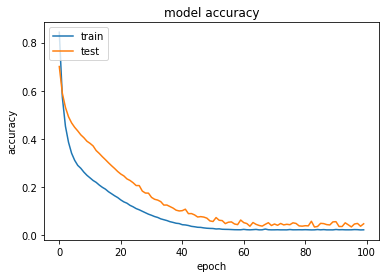

In [25]:
import matplotlib.pyplot as plt
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
#Testing
dir = os.listdir('./test_txt/')
test_cat, test_index = read_txt('./test_txt/',dir)

In [31]:
test_df = []
for i in range(len(test_index)):
    row = []
    for w in keywords:
        vecs = []
        for word in test_cat[w][i]:
            if word in embed_keys:
                vecs.append(embeddings_dict[word])
            else:
                vecs.append(embeddings_dict['<unk>'])
        vecs = np.array(vecs)
        va = np.average(vecs, axis = 0)
        cosine = None
        if np.isnan(va).any():
            cosine = 0
        else:
            vb = jd_vec[w]
            cosine = dot(va,vb)/(norm(va)*norm(vb))
        
        row.append(cosine)
    
    test_df.append(row)

C:\Users\sriva\AppData\Roaming\Python\Python39\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\sriva\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
test_sim = pd.DataFrame(test_df, index=test_index, columns=keywords)
test_sim.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, candidate_004.txt to candidate_146.txt
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   personal    60 non-null     float64
 1   projects    60 non-null     float32
 2   experience  60 non-null     float32
 3   skills      60 non-null     float32
 4   education   60 non-null     float32
dtypes: float32(4), float64(1)
memory usage: 1.9+ KB


In [33]:
txs = np.array(test_sim)
print(txs.shape)

(60, 5)


In [72]:
ans = model.predict(txs)
ans = np.reshape(ans, (ans.shape[0],1))
ans = ans*100 

In [35]:
def write(ans,test_index):
    ans = np.reshape(ans, (ans.shape[0],1))
    ans_index = np.array([x[:-4] for x in test_index])
    ans_index = np.reshape(np.ravel(ans_index) , ans.shape)
    ans = np.concatenate([ans_index,ans] , axis = 1)
    ans_df = pd.DataFrame(ans, index=None, columns=['CandidateID','Match Percentage'])
    print("Written new file")
    ans_df.to_csv('submission.csv',index=None)


In [73]:
## Trying other models
from sklearn.svm import SVR
svr = SVR(C=1.0,epsilon=0.2)
svr.fit(xs,ys)
ans_ =svr.predict(txs)
ans_ = np.reshape(ans_, (ans_.shape[0],1))
ans_ = ans_*100

# write(ans_, test_index)

In [81]:
take = np.copy(ans_)
for c in [1,5,10,80,110,120]:
    for e in [0.1, 0.002, 0.3, 0.83, 0.99]:
        svr = SVR(C = c, epsilon=e)
        svr.fit(xs,ys)
        ansx = svr.predict(txs)
        ansx = np.reshape(ansx, (ansx.shape[0],1))
        ansx = ansx*100
        take = np.concatenate([take,ansx],axis = 1)
        

print(take.shape)

(60, 31)


In [82]:
# xx = np.concatenate([ans,ans_], axis = 1)
# xx = np.max(xx, axis = 1)
# xx
take = np.min(take, axis =1)
write(take, test_index)

In [77]:
# write(xx, test_index)

In [83]:
sim_df

[[0.8883778, 0.29592833, 0.415252, 0.6364191, 0.8569552],
 [0.61097926, 0.23415965, 0.77697176, 0.7627605, 0.88227266],
 [0.66810286, 1.0, 0.62066585, 0.92462736, 0.75430495],
 [0.6947064, 0.37840423, 0.6942319, 0.8254774, 0.7708976],
 [0.9067139, 0.3005535, 0.76933324, 0.8814044, 0.77308196],
 [0.8622184, 0.26828837, 0.5923649, 0.8857072, 0.8472573],
 [0.7662991, 0.29844406, 0.71198624, 0.89622736, 0.8148804],
 [0.87884367, 1.0, 0.7653649, 0.9167172, 0.70842457],
 [0.8062151, 0.37531516, 0.7211594, 0.62105846, 0.8475659],
 [0.89601, 1.0, 0.7691308, 0.49025878, 0.39326173],
 [0.8031282, 0.39070997, 0.415252, 0.9175321, 0.39326173],
 [0.65824354, 0.28509477, 0.71453303, 0.80462074, 0.76407284],
 [0.8402332, 0.20913859, 0.7447718, 0.841462, 0.75217324],
 [0.66937876, 0.32378915, 0.7058372, 0.8362547, 0.8839337],
 [0.9144753, 0.27800855, 0.78372127, 0.9103799, 0.7644413],
 [0.8660931, 0.38663623, 0.6984991, 0.9099471, 0.70065427],
 [0.86044085, 1.0, 0.73467994, 0.49025878, 0.39326173],
 [

In [36]:
from sklearn.linear_model import Ridge
ridge = Ridge()
ridge.fit(xs,ys)
ansr = ridge.predict(txs)
ansr = ansr*100
write(ansr, test_index)

Written new file
